<a href="https://colab.research.google.com/github/jcandane/StochasticPhysics/blob/main/gpcam_spectratest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import h5py
from tqdm import tqdm

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import scipy

In [2]:
try:
    from gpcam.autonomous_experimenter import AutonomousExperimenterFvGP, AutonomousExperimenterGP
except:
    !pip install gpcam==8.0.4
    from gpcam.autonomous_experimenter import AutonomousExperimenterFvGP, AutonomousExperimenterGP

try:
    import GPy
except:
    !pip install GPy
    import GPy

try:
    from rcf_gpy import RCF
except:
    !wget https://raw.githubusercontent.com/jcandane/RCF/main/rcf_gpy.py
    from rcf_gpy import RCF

## SpectraLandscape object

In [3]:
def construct_Wigner(R_ix):
    ###### create: random-Matrix à la Wigner
    l       = int( 0.5*(np.sqrt(8*R_ix.shape[1]+1)-1) )
    M       = np.zeros((R_ix.shape[0], l, l), dtype=R_ix.dtype)
    i, j    = np.triu_indices(l, k=0)
    for n in range(R_ix.shape[0]):
        M[n, i, j] = R_ix[n] ## wrap this into a symmetric matrix
        M[n, j, i] = R_ix[n]
    return M

class SpectraLandscape():
    """ built: 3/27/2024
    this an object of a Random-Contionus-Function (RCF), with-respect-to a gpy kernel
    RCF : IN -> OUT = R^(d)
    we define a prior, and then sample to form a posterior.
    """

    def __init__(self, Domain:np.ndarray, d:int=100, N:int=17, seed:int=777,
                 l:int=10, d_min:np.float64=0, d_max:np.float64=1., γ:np.float64=0.0,
                 IN_noise=None, OUT_noise=None,
                 kernel=GPy.kern.RBF):
        """ !! note datatypes should be tf.float64 for stable Cholesky-operations
        GIVEN >
             Domain : 2d-np.ndarray (with shape=(d,2), with d=# of dims )
                  N : int (number-of-defining-points)
                 d : int (Multiple-Output Dimension)
             **seed : int
           **kernel : GPy.kern
         **IN_noise : 1d-np.ndarray (len == Domain.shape[1])
        **OUT_noise : 1d-np.ndarray (len == d)

        GET   >
            None
        """

        self.dtype  = np.float64
        self.IN     = Domain.astype(self.dtype)  ### : np.ndarray (IN-space range)
        self.N      = N      ### number of defining points
        self.d      = d     ### int (dimension of OUT)
        self.l      = l    ### : inter (features in the spectra)
        self.kernel = kernel(self.IN.shape[0])
        self.seed   = seed ### define pseudo-random seed
        self.d_min  = d_min
        self.d_max  = d_max
        self.γ      = γ

        self.MO     = self.l*(self.l+1)//2

        np.random.seed( self.seed )

        ### define anisotropic i.i.d white-noise
        if IN_noise is None:
            self.IN_noise=np.zeros(self.IN.shape[0], dtype=self.dtype)
        else:
            self.IN_noise = IN_noise
        if OUT_noise is None:
            self.OUT_noise=np.zeros(self.MO, dtype=self.dtype)
        else:
            self.OUT_noise = OUT_noise

        ### define IN-space defining-points
        self.R_ix  = np.random.uniform(0,1, (self.N, self.IN.shape[0])).astype(self.dtype)
        self.R_ix *= (self.IN[:,1] - self.IN[:,0])
        self.R_ix += self.IN[:,0]

        ### compute cholesky-factorization
        ### this will fail if K is not-PSD LinAlgError: Matrix is not positive definite
        try:
            L_ij = np.linalg.cholesky( self.kernel.K( self.R_ix ) ) ## not immutable
        except:
            #print("not PSD added to diag")
            L_ij = np.linalg.cholesky( self.kernel.K( self.R_ix ) + np.diag( 1.e-8 * np.random.rand(self.N).astype(self.dtype) ) )

        ### compute OUT-space defining-points
        D_iX  = np.random.normal(0,1,(self.N, self.MO)).astype(self.dtype)
        D_iX *= np.diag(L_ij)[:,None]
        D_iX  = np.matmul(L_ij, D_iX)

        self.S_iX  = scipy.linalg.cho_solve((L_ij, True), D_iX)

    def evaluate(self, D_ax):
        """ evaluate for arbitrary values/points in OUT given points in IN.
        GIVEN >
              self
              D_ax : 2d-np.ndarray (D_ax ∈ IN)
        GET   >
              D_aX : 2d-np.ndarray (D_aX ∈ OUT, note captial 'X')
        """
        D_ax += self.IN_noise*np.random.normal(0,1,D_ax.shape).astype(self.dtype)
        D_aX  = np.matmul( self.kernel.K(D_ax, self.R_ix), self.S_iX )
        D_aX += self.OUT_noise*np.random.normal(0,1,D_aX.shape).astype(self.dtype)
        return D_aX

    def get_freq(self):
        return np.linspace(self.d_min, self.d_max, self.d)

    def t(self):
        return np.arange(self.d) / (self.d_max - self.d_min)

    def __call__(self, D_ax):

        df = (self.d_max-self.d_min)/self.d ## :float,  frequnecy resolution of the detector


        D_aX = self.evaluate(D_ax)
        M    = construct_Wigner(D_aX)
        E_ni, v_nij = np.linalg.eigh(M)
        A_nl = v_nij[:,:,0]

        E_ni = ((E_ni-self.d_min)/df).astype(int)
        mask = np.logical_or( (E_ni < 0) , (E_ni > self.d-1) )
        E_ni[mask] = 0
        A_nl[mask] = 0.

        detector_f = np.ones(D_ax.shape[0])[:,None]*np.linspace(self.d_min, self.d_max, self.d)[None,:]  ### detector frequency bins
        detector_A = np.ones(D_ax.shape[0])[:,None]*np.zeros( self.d )[None,:]  ### detector

        ###?
        for n in range(D_ax.shape[0]):
            detector_A[n,E_ni[n,:]] = np.abs(A_nl[n,:])**2 ### IDEAL (stick-figure) detector intensities
        #detector_A[:,E_ni[:]] = np.abs(A_nl[:])**2
        t   = np.arange(self.d) / (self.d_max-self.d_min)
        OUT = np.abs( np.fft.ifft( np.fft.fft( detector_A , axis=1)*np.exp(-self.γ*self.t())[None,:] , axis=1 ) )
        return OUT

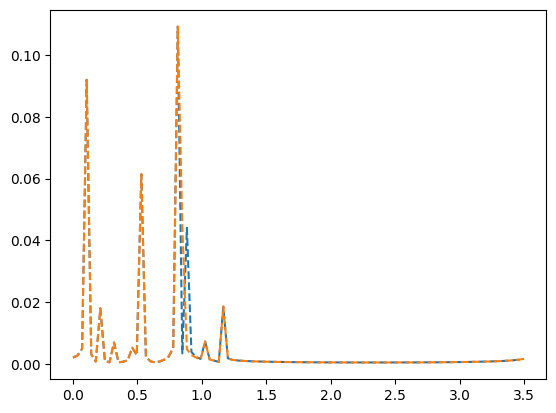

In [4]:
domain = np.array([[0,10.],[0,11.]])

f = SpectraLandscape(domain, d=100, γ=0.01, l=20, d_max=3.5)

As = f( np.array([[0.205,10.],[0.2,10.],[4.5,8.4]]) ) #,[0.68,7.5]]) )
As = f( np.array([[0.205,10.],[0.2,10.]]) )
#As = f( np.array([[0.25,10.] ]) )

plt.plot(f.get_freq(), As.T, linestyle="dashed")
plt.show()

## gpcam interface

In [5]:
#################################################

def gpcam_to_h5(data, filename="to_vintrumentxx.h5"):
    """ this function reads gpcam's data, and creates an h5 file (to be read by the instrument)
    GIVEN   > data : List[dict] (gpCAM dataset datatype, !contains various datatypes)
            **filename : str (optional, str specifying the output h5 file)
    GET     > None
    """

    to_analyze=[]
    for entry in data:
        to_analyze.append(entry["x_data"])
    to_analyze = np.asarray(to_analyze) ## make into a np.array, D_ax

    h5f = h5py.File(filename, "w")
    h5f.create_dataset("dataset_1", data=to_analyze)
    h5f.close()
    return None

def h5_to_vinstrument(filename="to_vintrumentxx.h5"):
    """
    this function reads a h5 file, to obtain a 2d-numpy.array (to be used by the virtual-intrument)
    GIVEN > **filename : str
    GET   > x_data : np.ndarray{2d} (D_ax, 1st-index enumerates snapshots, 2nd-index enumerates IN-coordiante, i.e. D_ax)
    """

    h5f    = h5py.File(filename, "r")
    x_data = np.asarray(h5f.get('dataset_1'))
    h5f.close()
    return x_data ### numpy.array of dimensions ( samples , coordinates ) i.e. D_ax

def vinstrument_to_h5(y_data, filename="from_vintrumentxx.h5"):
    """
    this function obtained the vintrument's y_data, along with other meta-data saves to an h5
    GIVEN > y_data : np.ndarray{2d} (2d-np.array, 1st-index : data-entry number, 2nd-index : OUT-coordinate, i.e. D_aX)
    GET >   None
    """

    h5f = h5py.File(filename, "w")
    h5f.create_dataset("dataset_1", data=y_data)
    h5f.close()
    return None

def h5_to_gpcam(data, filename="from_vintrumentxx.h5"):
    """ this function updates gpcam's "data" variable (List[dict]), by reading a h5 file.
    GIVEN > data : List[dict] (gpCAM dataset datatype, !contains various datatypes)
            **filename : str (optional, str specifying the input h5 file)
    GET   > data : List[dict] (gpCAM dataset datatype, !contains various datatypes)
    """
    h5f    = h5py.File(filename, "r")
    y_data = np.asarray(h5f["dataset_1"]) ## D_aX
    h5f.close()

    for a, entry in enumerate(data):
        entry["y_data"] = np.asarray([y_data[a]]) ### this should have the shape of (2,1) as given in instrument
        entry["output positions"] = np.asarray([np.arange(len(y_data[a]))]).T #np.array([[0],[1]]) ### this is important for fvGP object!
        #entry["output positions"] = np.asarray([np.arange(f.D)]).T

    return data

class gpcam_test_instrument():
    """
    uses RCF function to create a test instrument in gpcam, while writing h5 files
    out to interface.
    """

    def __init__(self, Domain, D=100, N=17, seed=777, kernel=None,
                 γ=0.00):
        self.domain = Domain ### numpy.2darray
        self.D      = D      ### int (dimension of OUT)
        self.N      = N
        self.seed   = seed
        self.γ      = γ
        self.rcf    = SpectraLandscape(self.domain, d=self.D, γ=self.γ, l=20, d_max=3.5) #RCF(self.domain, N=self.N, MO=self.D, seed=self.seed)

    #################################
    def vinstrument(self):
        """ python-function for virtual-instrument, reads and writes h5 files
        GIVEN > None
        GET   > None
        """

        x_data = h5_to_vinstrument()

        y_data = self.rcf(x_data)

        vinstrument_to_h5(y_data)

        return None

    def __call__(self, data):

        ### gpcam -> h5 (x-coordinates only)
        gpcam_to_h5(data)

        ### vintrument()
        self.vinstrument()

        ### h5 -> gpcam (everything)
        data = h5_to_gpcam(data)

        return data
    #################################

## 27 mins!

In [6]:
domain = np.array([[0,10.],[0,11.]])

apparatus = gpcam_test_instrument(domain, D=100)

my_experiment = AutonomousExperimenterFvGP(apparatus.domain,
                                            apparatus.D, 1,
                                            init_dataset_size=10,
                                            instrument_function=apparatus)
my_experiment.train()
my_experiment.go(15)

 /usr/local/lib/python3.10/dist-packages/fvgp/fvgp.py:280: UserWarning:Hyperparameter bounds have been initialized automatically                     
 for the default kernel in fvgp. They will automatically used for the training.                    
 However, you can also define and provide new bounds.
 /usr/local/lib/python3.10/dist-packages/fvgp/fvgp.py:287: UserWarning:No noise function or measurement noise provided. Noise variances will be set to 1% of mean(y_data).


In [9]:
my_experiment.go(12) ## +2m

 /usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentialevolution.py:487: UserWarning:differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'


In [14]:
my_experiment.go(15) ## +2m

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentialevolution.py:487: UserWarning:

differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'



## lets plot the selected spectra:

In [16]:
my_experiment.x_data.shape, my_experiment.y_data.shape

((15, 2), (15, 100))

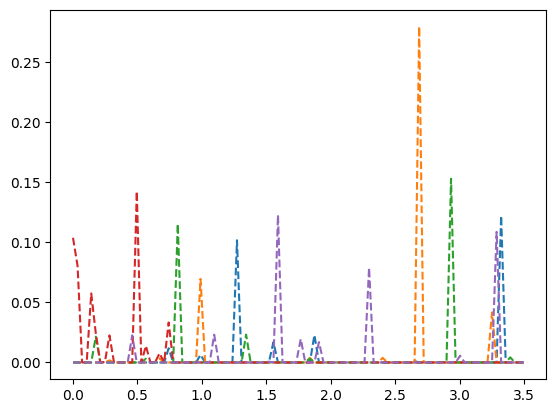

In [21]:
plt.plot(apparatus.rcf.get_freq(), my_experiment.y_data[10:,:].T, linestyle="dashed")
plt.show()